<a href="https://colab.research.google.com/github/gulliiii/SNIP_project/blob/main/SNIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we import the necessary packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn.utils.prune as prune
from torchvision import datasets, transforms

## Progress bar
from tqdm.notebook import tqdm

import copy
import types

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# MNIST

Loading the dataset.

In [ ]:

transform_mnist = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
         ])

mnist_1 = datasets.MNIST('../data', train=True, download=True,
                      transform=transform_mnist)
mnist_2 = datasets.MNIST('../data', train=False,
                      transform=transform_mnist)

val_ratio = 0.1
val_size = int(val_ratio*len(mnist_1))
train_mnist, val_mnist = data.random_split(mnist_1, [len(mnist_1) - val_size, val_size])

train_mnist_loader = data.DataLoader(train_mnist, batch_size = 100, shuffle = True)
val_mnist_loader = data.DataLoader(val_mnist, batch_size = 1000, shuffle = True)
test_mnist_loader = data.DataLoader(mnist_2, batch_size = 1000, shuffle = False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.7MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.79MB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.06MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



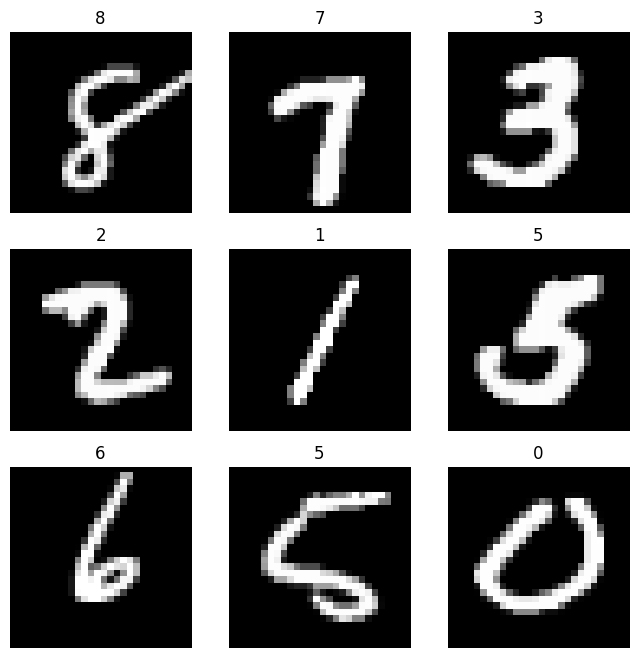

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_mnist), size=(1,)).item()
    img, label = train_mnist[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

# CIFAR10

## LeNet5

In [ ]:
class LeNet5(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


# ResNet18

# DEPENDENCIES

In [ ]:
#This is the train function
def train(model, train_loader, optimizer, loss, spars=0, epoch=1, device="cpu"):
  model.train()
  tk0 = tqdm(train_loader, total=int(len(train_loader)), desc=f"TRAIN | Epoch {epoch} | Sparsity: {spars}")
  for batch_idx, (data, target) in enumerate(tk0):
        data = data.to(device)
        target = target.to(device)
        y = model(data)
        this_loss = loss(y, target)
        error = torch.mean((y.argmax(dim=1) != target)*100.0)
        optimizer.zero_grad()
        this_loss.backward()
        optimizer.step()
        tk0.set_postfix(loss=this_loss.item(), error = error.item())
  return this_loss.item(), error.item()

In [ ]:
class AverageMeter(object):

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count




#This is the validation function
def valid(model, val_loader, loss, spars=0, epoch=1, device="cpu"):
  tk0 = tqdm(val_loader, total=int(len(val_loader)), desc=f"VALIDATION | Epoch {epoch} | Sparsity: {spars}")
  mean_val_loss = AverageMeter("val_loss")
  mean_val_error = AverageMeter("val_error")
  model.eval()
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tk0):
          data = data.to(device)
          target = target.to(device)
          y = model(data)
          this_loss = loss(y, target)
          this_error = torch.mean((y.argmax(dim=1) != target)*100.0)
          mean_val_loss.update(this_loss)
          mean_val_error.update(this_error)
          tk0.set_postfix(loss = mean_val_loss.avg.item(), error = mean_val_error.avg.item())
  return mean_val_loss.avg.item(), mean_val_error.avg.item()

#This is the test function
def test(model, test_loader, loss, spars=0, device="cpu"):
  tk0 = tqdm(test_loader, total=int(len(test_loader)), desc=f"TEST | Sparsity: {spars}")
  mean_test_loss = AverageMeter("test_loss")
  mean_test_error = AverageMeter("test_error")
  model.eval()
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tk0):
          data = data.to(device)
          target = target.to(device)
          y = model(data)
          this_loss = loss(y, target)
          this_error = torch.mean((y.argmax(dim=1) != target)*100.0)
          mean_test_loss.update(this_loss)
          mean_test_error.update(this_error)
          tk0.set_postfix(loss=mean_test_loss.avg.item(), error = mean_test_error.avg.item())
  return mean_test_loss.avg.item(), mean_test_error.avg.item()


In [ ]:

def snip_forward_conv2d(self: nn.Conv2d, x: torch.Tensor) -> torch.Tensor:
    """Custom forward for Conv2d layers using a weight mask."""
    return F.conv2d(x, self.weight * self.weight_mask, self.bias)


def snip_forward_linear(self: nn.Linear, x: torch.Tensor) -> torch.Tensor:
    """Custom forward for Linear layers using a weight mask."""
    return F.linear(x, self.weight * self.weight_mask, self.bias)


def SNIP(model, spars, train_loader, loss, device = "cpu"):
    """
    Implements the SNIP pruning algorithm to determine which parameters
    to keep for a given sparsity level.

    This function creates a copy of the model, attaches a mask to each
    prunable layer (Conv2d and Linear), overrides their forward passes,
    and then computes the gradient-based importance scores.

    Parameters:
        model (nn.Module): The model to be pruned.
        sparsity (float): Fraction of parameters to prune (0 <= sparsity < 1).
        train_loader: A DataLoader from which the first mini-batch is taken.
        loss_fn: Loss function to compute the loss.
        device (str): Device to run the model on ("cpu" or "cuda").

    Returns:
        List[torch.Tensor]: A list of binary masks for each prunable layer.
    """
    # Fetch one mini-batch and send to device.
    data, target = next(iter(train_loader))
    data, target = data.to(device), target.to(device)

    # Create a copy of the model and move it to the specified device.
    snip_model = copy.deepcopy(model).to(device)

    # Attach a weight mask to each prunable layer and override its forward method.
    for layer in snip_model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Initialize a mask of ones (same shape as weights).
            layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
            # Freeze the original weights so they are not updated.
            layer.weight.requires_grad = False

            # Override the forward pass with our custom SNIP forward.
            if isinstance(layer, nn.Conv2d):
                layer.forward = types.MethodType(snip_forward_conv2d, layer)
            elif isinstance(layer, nn.Linear):
                layer.forward = types.MethodType(snip_forward_linear, layer)

    # Forward pass and compute gradients.
    snip_model.zero_grad()
    output = snip_model(data)
    loss_value = loss(output, target)
    loss_value.backward()

    # Collect the absolute gradients of the weight masks.
    grads_abs = [
        torch.abs(layer.weight_mask.grad)
        for layer in snip_model.modules()
        if isinstance(layer, (nn.Conv2d, nn.Linear))
    ]

    # Concatenate all gradients into a single vector and normalize.
    all_scores = torch.cat([g.flatten() for g in grads_abs])
    total_score = torch.sum(all_scores)
    all_scores_normalized = all_scores / total_score

    # Determine the threshold score to keep (1 - sparsity) fraction of parameters.
    num_params_to_keep = int(len(all_scores_normalized) * (1 - spars))
    threshold_scores, _ = torch.topk(all_scores_normalized, num_params_to_keep, sorted=True)
    acceptable_score = threshold_scores[-1]

    # Create binary masks.
    keep_masks = [
        ((g / total_score) >= acceptable_score).float()
        for g in grads_abs
    ]

    # Optionally print the total number of parameters kept.
    total_kept = sum(mask.sum().item() for mask in keep_masks)
    print(f"Total parameters kept: {total_kept}")

    return keep_masks

In [ ]:
def apply_prune_mask(model, keep_masks):
    """
    Applies pruning masks to the model's prunable layers (Conv2d and Linear).
    For each such layer, the weights corresponding to zeros in the keep mask are
    set to zero, and a hook is registered to ensure gradients for pruned weights
    remain zero during backpropagation.

    Parameters:
        model (nn.Module): The PyTorch model.
        keep_masks (iterable of torch.Tensor): One mask per prunable layer.
    """
    # Filter out the layers we want to prune (Conv2d and Linear)
    prunable_layers = [
        layer for layer in model.modules()
        if isinstance(layer, (nn.Conv2d, nn.Linear))
    ]

    for layer, keep_mask in zip(prunable_layers, keep_masks):
        if layer.weight.shape != keep_mask.shape:
            raise ValueError(
                f"Shape mismatch: {layer.weight.shape} vs {keep_mask.shape}"
            )

        # Zero-out the pruned weights using a no_grad context
        with torch.no_grad():
            layer.weight[keep_mask == 0] = 0.

        # Register a hook to maintain zero gradients for pruned weights.
        # Using a lambda with a default argument ensures early binding.
        layer.weight.register_hook(lambda grad, mask=keep_mask: grad * mask)

# MAIN - MNIST

In [ ]:
lenet5 = LeNet5().to(device)
sparsities_mnist = [0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]

In [ ]:
loss = F.nll_loss
snipped_models = {}

for spar in sparsities_mnist:
  lenet5_copy = copy.deepcopy(lenet5)
  keep_masks = SNIP(lenet5, spar, train_mnist_loader, loss, device)
  apply_prune_mask(lenet5_copy, keep_masks)
  snipped_models[spar] = lenet5_copy

tensor(1199648, device='cuda:0')
tensor(899736, device='cuda:0')
tensor(599825, device='cuda:0')
tensor(299912, device='cuda:0')
tensor(119964, device='cuda:0')
tensor(59982, device='cuda:0')
tensor(11996, device='cuda:0')
tensor(5998, device='cuda:0')
tensor(1199, device='cuda:0')


In [ ]:
# Hyperparameters
epochs = 30
learning_rate = 0.01

train_losses = {}
train_errors = {}
val_losses = {}
val_errors = {}

for spar, snipped_model in snipped_models.items():
  optimizer = optim.SGD(snipped_model.parameters(), lr = learning_rate)
  for epoch in range(1, epochs + 1):
    train_losses[spar], train_errors[spar] = train(snipped_model, train_mnist_loader, optimizer, loss, spar, epoch, device)
    val_losses[spar], val_errors[spar] = valid(snipped_model, val_mnist_loader, loss, spar, epoch, device)

TRAIN | Epoch 1 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.25:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.25:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.50:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.50:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.75:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.75:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.90:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.90:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.95:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.95:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 0.99:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 0.99:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 1 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 1 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 2 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 2 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 3 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 3 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 4 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 4 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 5 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 5 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 6 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 6 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 7 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 7 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 8 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 8 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 9 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 9 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 10 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 10 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 11 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 11 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 12 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 12 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 13 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 13 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 14 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 14 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 15 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 15 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 16 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 16 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 17 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 17 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 18 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 18 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 19 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 19 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 20 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 20 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 21 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 21 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 22 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 22 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 23 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 23 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 24 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 24 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 25 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 25 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 26 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 26 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 27 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 27 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 28 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 28 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 29 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 29 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

TRAIN | Epoch 30 | Sparsity: 1.00:   0%|          | 0/540 [00:00<?, ?it/s]

VALIDATION | Epoch 30 | Sparsity: 1.00:   0%|          | 0/6 [00:00<?, ?it/s]

## Model Evaluation

In [ ]:
test_losses = {}
test_errors = {}

for spar, snipped_model in snipped_models.items():
  test_losses[spar], test_errors[spar] = test(snipped_model, test_mnist_loader, loss, spar, device)

TEST | Sparsity: 0.00:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.25:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.50:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.75:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.90:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.95:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.99:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 0.99:   0%|          | 0/10 [00:00<?, ?it/s]

TEST | Sparsity: 1.00:   0%|          | 0/10 [00:00<?, ?it/s]

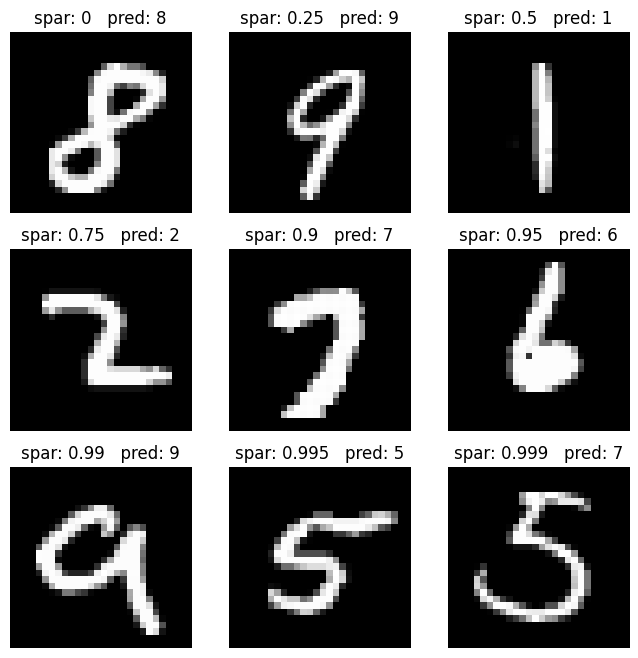

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_2), size=(1,)).item()
    img, label = mnist_2[sample_idx]
    figure.add_subplot(rows, cols, i)
    pred_label = snipped_models[sparsities_mnist[i-1]](img.unsqueeze(0).to(device)).argmax(dim=1)
    plt.title(f"spar: {sparsities_mnist[i-1]}   pred: {pred_label.item()}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

Text(0.5, 1.0, 'Test Error')

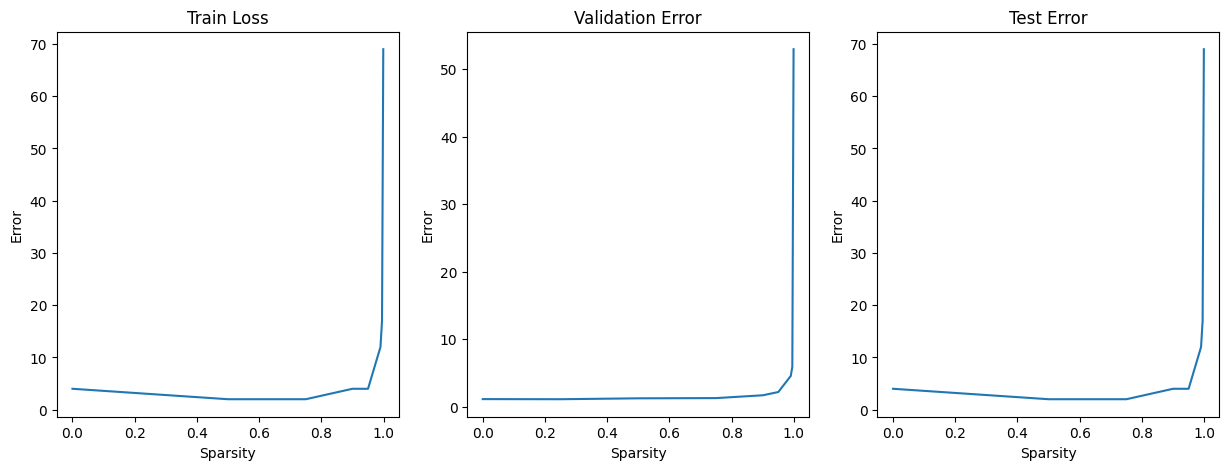

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(sparsities_mnist, train_errors.values(), label="Train Error")
ax[0].set_xlabel("Sparsity")
ax[0].set_ylabel("Error")
ax[0].set_title("Train Error")
ax[0].set_xticks(sparsities_mnist)
ax[0].set_xticklabels(sparsities_mnist)

ax[1].plot(sparsities_mnist, val_errors.values(), label="Validation Error")
ax[1].set_xlabel("Sparsity")
ax[1].set_ylabel("Error")
ax[1].set_title("Validation Error")
ax[1].set_xticks(sparsities_mnist)
ax[1].set_xticklabels(sparsities_mnist)

ax[2].plot(sparsities_mnist, test_errors.values(), label="Test Loss")
ax[2].set_xlabel("Sparsity")
ax[2].set_ylabel("Error")
ax[2].set_title("Test Error")
ax[2].set_xticks(sparsities_mnist)
ax[2].set_xticklabels(sparsities_mnist)
